In [1]:
using PyPlot
using Random
using Statistics
import JSON: parsefile
import StatsBase
using Printf
using LsqFit
plt.style.use("seaborn-dark-palette")

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1342
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1342


In [2]:
function augchance(lvl, clvl, chances)
    (0.9 + (clvl*1.5)^0.5/200)^(lvl+1) + chances
end

function bust(clvl, chances; count=1, stop=Inf, start=0)
    itemLvl = start
    while ( rand() < augchance(itemLvl, clvl, chances) ) && (itemLvl < stop)
        itemLvl += 1
    end
    itemLvl
end

function multi(clvl, chances, count; kwargs...)
    kwargs = Dict(kwargs)
    itemLvl = get(kwargs, :ilvl, 0)
    while count > 1
        rolls = rand(count) .< augchance(itemLvl, clvl, chances)
        count = sum(rolls)
        if count > 0
            itemLvl += 1
        end
    end
    itemLvl
end

function prism(clvl, chances)
    stops = collect(1:1:20)
    x = []
    for st in stops
        push!(x, mean([bust(clvl, chances; stop=st) for a in collect(1:1_000_000)]))
    end
    stops, x
end

prism (generic function with 1 method)

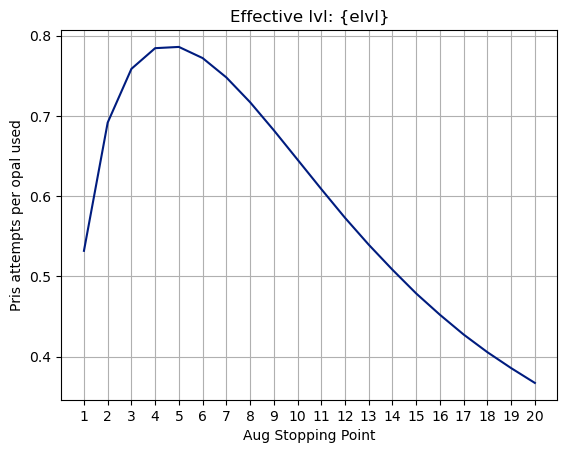

In [9]:
elvl = 114
pp = prism(elvl, 0.06);
plt.plot(pp[1], pp[2] ./ (pp[1].+0.88))
plt.xticks(pp[1])
plt.xlabel("Aug Stopping Point")
plt.ylabel("Pris attempts per opal used")
plt.title("Effective lvl: {elvl}")
plt.grid()

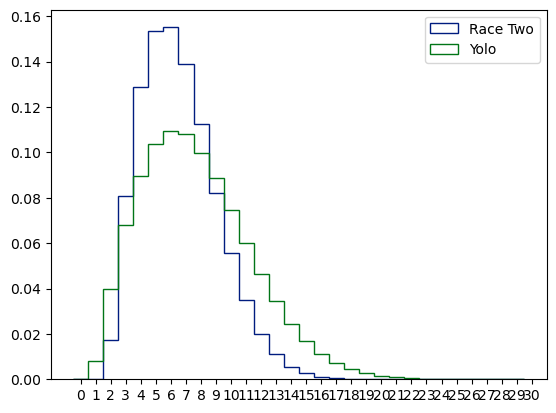

mean(y) = 7.676038
mean(x) = 6.566902


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [14]:
bins = collect(0:1:30)
x = [multi(114, 0.06, 2) for a in collect(1:1_000_000)];
y = [bust(114, 0.06) for a in collect(1:1_000_000)];
@show mean(y)
@show mean(x)
plt.hist(x, bins=bins, align="left", histtype="step", density=true, label="Race Two")
plt.hist(y, bins=bins, align="left", histtype="step", density=true, label="Yolo")
plt.xticks(bins)
plt.legend()
plt.show()

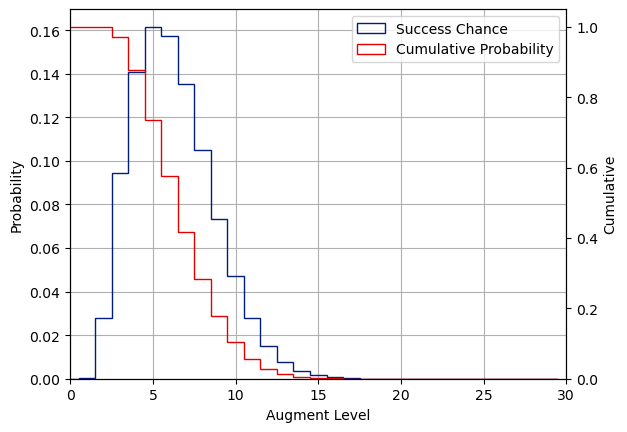

In [5]:
function dohist(data, bins)
    mn = mean(data)
    st = std(data)
    fig, ax1 = plt.subplots()
    pdf = ax1.hist(data, label="Success Chance", bins=bins, align="left", histtype="step", density=true)
    ax2 = ax1.twinx()
    cdf = ax2.hist(data, label="Cumulative Probability", bins=bins, align="left", histtype="step", density=true, cumulative=-1, color="xkcd:red")
    plt.xlim(minimum(bins), maximum(bins))
    ax1.grid()
    ax1.set_xlabel("Augment Level")
    ax1.set_ylabel("Probability")
    ax2.set_ylabel("Cumulative")
    fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    return (pdf, cdf)
end

a = dohist(x, bins);

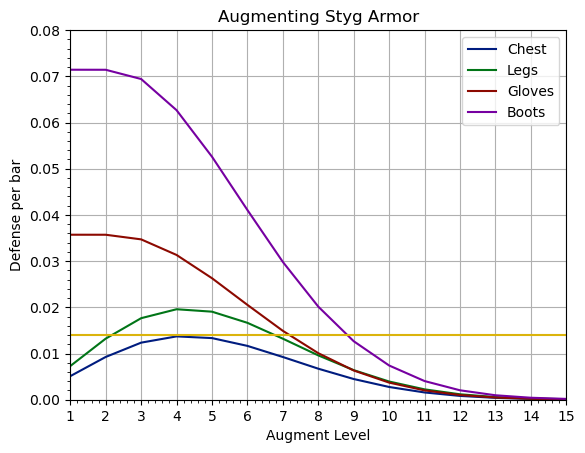

In [6]:
pdf, cdf = a
py, px = pdf[1:2]
px = px[1:end-1]
cy, cx = cdf[1:2]
cx = cx[1:end-1]

initCost = [440, 308, 0, 0]
augCost = [50, 35, 70, 35]
labels = ["Chest", "Legs", "Gloves", "Boots"]

for (i, a, l) in zip(initCost, augCost, labels)
    realCost = (i .+ a .* cx) ./ cy
    plt.plot(cx, cx ./ realCost * 2.5, label=l)
    plt.xlabel("Augment Level")
    plt.ylabel("Defense per bar")
    plt.yticks(collect(0:0.01:0.1))
    plt.xticks(cx)
    plt.minorticks_on()
    plt.ylim(0, 0.08)
    plt.xlim(1, 15)
end
plt.grid(which="major")
plt.axhline(0.014, color="xkcd:gold")
plt.title("Augmenting Styg Armor")
plt.legend();

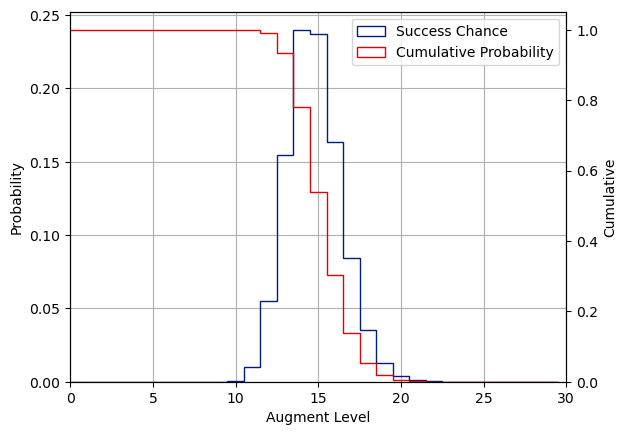

(([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7e-5  …  0.003873, 0.001145, 0.000312, 5.0e-5, 1.2e-5, 5.0e-6, 0.0, 0.0, 0.0, 0.0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  21, 22, 23, 24, 25, 26, 27, 28, 29, 30], PyCall.PyObject[PyObject <matplotlib.patches.Polygon object at 0x7faf5ba401f0>]), ([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.005397, 0.001524, 0.000379, 6.7e-5, 1.7e-5, 5.0e-6, 0.0, 0.0, 0.0, 0.0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  21, 22, 23, 24, 25, 26, 27, 28, 29, 30], PyCall.PyObject[PyObject <matplotlib.patches.Polygon object at 0x7faf5ba64a60>]))

In [7]:
# 35 scims starting at +5
bdata = [multi(102, 0.06, 40; ilvl=0) for a in collect(1:1_000_000)];
#plt.hist(bdata,bins=bins)
b = dohist(bdata, bins)

In [8]:
## Double check spreadsheet, get attempts and total augments
trials = 100_000
stp = 5
daggers = [bust(108, 0.06; stop=stp, start=0) for x in collect(1:trials)]

function tAugs(data, stop)
    stoppers = sum(data .== stop) * stop
    others = sum(data[data .!= stop] .+ 1)
    (stoppers + others)/length(data)
end
@show tAugs(daggers, stp)

tAugs(daggers, stp) = 4.80499


4.80499